In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

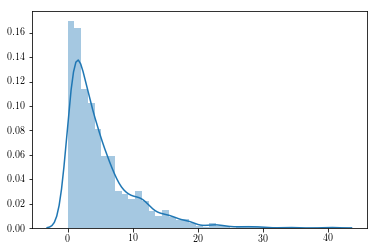

In [3]:
#Lets generate some exponentially increasing data
lambd = .2
d = np.random.exponential(scale = 1/lambd, size=1000)
sns.distplot(d)
plt.show()

In [4]:
code = '''
data {
    int<lower = 0> N;
    real d[N];
}
parameters {
    real beta;
}
model {
    beta ~ normal(-5., .1);
    d ~ exponential(beta);
}

'''
sm = pystan.StanModel(model_code = code, model_name='exp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL exp_9f03013864502fb432f46291402fab11 NOW.


In [5]:
dat = {'N': len(d),
      'd': d}
fit = sm.sampling(data=dat, iter=1500, chains=1)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


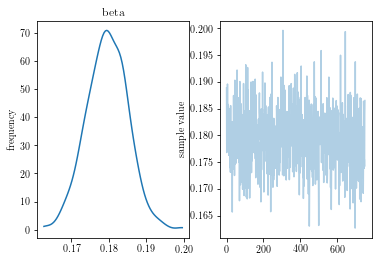

In [6]:
fit.plot()
plt.show()

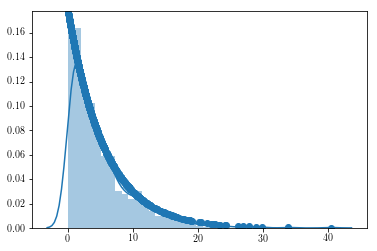

In [8]:
trace = fit.extract()
lambd = np.median(trace['beta'])
sns.distplot(d)
plt.scatter(d, lambd*np.exp(-d*lambd))


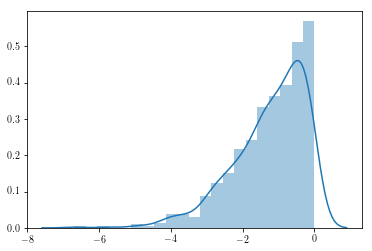

In [68]:
'''Now lets make a gaussian'''
true_m = 1.
true_sig = 2.
d = np.random.normal(true_m,true_sig,size=2000)
d = d[d<0.]
sns.distplot(d)
plt.show()

In [72]:
code = '''
data {
    int<lower = 0> N;
    real d[N];
    real hi;
    real lo;
}
parameters {
    real lambd;
}
model {
    lambd ~ normal(0, 1e6);
    for (n in 1:N)
        target += log(lambd*(exp(lambd*hi)-exp(lambd*lo))^-1) + lambd*d[n];
}

'''
sm = pystan.StanModel(model_code = code, model_name='offgauss')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL offgauss_e70aa96eab44a29d2cab1cd153f9b62b NOW.


In [77]:
dat = {'N': len(d),
      'd': d,
      'hi':d.max(),
      'lo':d.min()}
fit = sm.sampling(data=dat, iter=1000, chains=1)

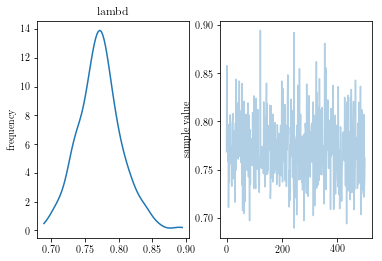

In [78]:
fit.plot()
plt.show()

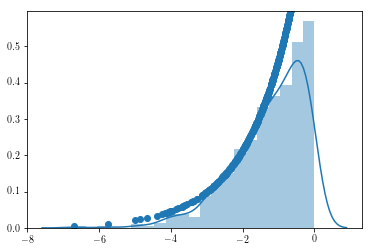

In [80]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(d)
p = np.exp(lambd*d)
plt.scatter(d,p)